In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk.corpus import brown

from gensim.models import KeyedVectors
import tensorflow as tf

from sklearn.model_selection import train_test_split,KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report

In [ ]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
tagged_sentences = brown.tagged_sents(tagset='universal')

In [ ]:
tagged_sentences[25]

[('On', 'ADP'),
 ('other', 'ADJ'),
 ('matters', 'NOUN'),
 (',', '.'),
 ('the', 'DET'),
 ('jury', 'NOUN'),
 ('recommended', 'VERB'),
 ('that', 'ADP'),
 (':', '.'),
 ('(', '.'),
 ('1', 'NUM'),
 (')', '.')]

In [ ]:
X_store, Y_store =[],[]
X, Y=[], []
for sentence in tagged_sentences:
    temp_x, temp_y =[],[]
    for word,tag in sentence:
        temp_x.append(word.lower())
        temp_y.append(tag)
    X.append(temp_x)
    Y.append(temp_y)
X_store=X
Y_store=Y

In [ ]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [ ]:
print(num_words)
print(num_tags)

49815
12


In [ ]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(X)
X_encoded = word_tokenizer.texts_to_sequences(X)

In [ ]:
tag_tokenizer = tf.keras.preprocessing.text.Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [ ]:
print(X[25])
print(X_encoded[25])

['on', 'other', 'matters', ',', 'the', 'jury', 'recommended', 'that', ':', '(', '1', ')']
[20, 73, 1720, 2, 1, 1634, 2402, 9, 67, 53, 179, 51]


In [ ]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 180


In [ ]:
X = X_encoded
Y = Y_encoded

In [ ]:
print(len(X),len(X[0]))
print(len(Y),len(Y[0]))

57340 25
57340 25


In [ ]:
path = 'gdrive/MyDrive/CS626/Assignment_2/GoogleNews-vectors-negative300.bin'
word2vec= KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
EMBEDDING_SIZE = 300
VOCAB_SIZE = len(word_tokenizer.word_index)+1

embedding_matrix = np.zeros((VOCAB_SIZE,EMBEDDING_SIZE))
word2id = word_tokenizer.word_index

for word,index in word2id.items():
    try:
        embedding_matrix[index,:] = word2vec[word]
    except KeyError:
        pass

In [ ]:
print(embedding_matrix.shape)

(49816, 300)


In [ ]:
#embedding_matrix[word_tokenizer.word_index['boy']]

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

In [ ]:
NUM_CLASSES = 13

In [ ]:
MAX_SENTENCE_LENGTH = 180
def processing(a,b):
    a = tf.keras.preprocessing.sequence.pad_sequences(a, maxlen=MAX_SENTENCE_LENGTH, padding="pre",truncating="post")
    b = tf.keras.preprocessing.sequence.pad_sequences(b, maxlen=MAX_SENTENCE_LENGTH, padding="pre",truncating="post")
    b = tf.keras.utils.to_categorical(b)
    return a,b

In [ ]:
# X_train, Y_train = processing(X_train,Y_train)
# X_test, Y_test = processing(X_test,Y_test)

In [ ]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim     = VOCAB_SIZE,
                                 output_dim    = EMBEDDING_SIZE,
                                 input_length  = MAX_SENTENCE_LENGTH,
                                 weights       = [embedding_matrix],
                                 trainable     = True
    ))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [ ]:
# model = get_model()
# model.summary()

In [ ]:
# model.fit(X_train,Y_train,batch_size=128,epochs=5)

In [ ]:
# model.evaluate(X_test,Y_test,verbose=1)

In [ ]:
def predict(model,sentence):
    org_length = len(sentence)
    res = []
    for word in sentence:
        res.append(word.lower())
    seq=[]
    for word in res:
      try:
        seq.append(word2id[word])
      except KeyError:
        seq.append(0)
    sentence = seq
    sentence = ([0] * (MAX_SENTENCE_LENGTH - len(sentence))) + sentence
    sentence = np.asarray(sentence).astype('int')
    sentence = np.reshape(sentence,(1,MAX_SENTENCE_LENGTH))
    pred = model.predict(sentence)[0]
    output=[]
    id2tag=dict()
    for key,val in tag_tokenizer.word_index.items():
        id2tag[val]=key
    for i in range(MAX_SENTENCE_LENGTH):
        temp = np.argsort(pred[i])
        id = temp[-1]
        if id!=0:
            output.append(id2tag[id].upper())
        else:
            output.append('X')
    print(output[-org_length:])

In [ ]:
kfold = KFold(n_splits=5,shuffle=True,random_state=19)
y_true_list,y_pred_list = [], []
X = np.array(X)
Y = np.array(Y)
fold = 1
final_model = 0
accuracy_prev = 0
for train_index, test_index in kfold.split(X,Y):
    X_train, X_test, Y_train, Y_test = X[train_index], X[test_index], Y[train_index], Y[test_index]
    X_train, Y_train = processing(X_train,Y_train)
    X_test, Y_test = processing(X_test,Y_test)
    model = get_model()
    model.fit(X_train,Y_train,batch_size=128,epochs=5,verbose=1)
    del1 = model.predict(X_test,verbose=0)
    y_pred = np.zeros((del1.shape[0],del1.shape[1]))  
    y_org = np.zeros((del1.shape[0],del1.shape[1]))
    for i in range(del1.shape[0]):
        for j in range(del1.shape[1]):
          y_pred[i][j] = np.argmax(del1[i][j])
          y_org[i][j] = np.argmax(Y_test[i][j])
    y_pred = y_pred.flatten()
    y_org = y_org.flatten()
    y_pred1, y_org1 = [],[]
    for i in range(y_org.shape[0]):
        if(y_org[i]==0):
            continue
        else:
            if(y_pred[i]==0):
                y_pred1.append(2)
                y_org1.append(y_org[i])
            else:
                y_pred1.append(y_pred[i])
                y_org1.append(y_org[i])
            
    y_true_list.append(np.array(y_org1))
    y_pred_list.append(np.array(y_pred1))
    accuracy = accuracy_score(y_true_list[-1],y_pred_list[-1],normalize=True)
    print(f'Accuracy for Fold {fold} : {accuracy}')
    if(accuracy>accuracy_prev):
        accuracy_prev = accuracy
        final_model = model
    fold+=1

Epoch 1/5
359/359 [==============================] - 9s 15ms/step - loss: 0.2447 - accuracy: 0.9832
Epoch 2/5
359/359 [==============================] - 5s 14ms/step - loss: 0.0141 - accuracy: 0.9944
Epoch 3/5
359/359 [==============================] - 5s 14ms/step - loss: 0.0129 - accuracy: 0.9946
Epoch 4/5
359/359 [==============================] - 5s 14ms/step - loss: 0.0126 - accuracy: 0.9947
Epoch 5/5
359/359 [==============================] - 5s 14ms/step - loss: 0.0124 - accuracy: 0.9947
Accuracy for Fold 1 : 0.9480155018040892
Epoch 1/5
359/359 [==============================] - 6s 15ms/step - loss: 0.2118 - accuracy: 0.9836
Epoch 2/5
359/359 [==============================] - 5s 15ms/step - loss: 0.0141 - accuracy: 0.9944
Epoch 3/5
359/359 [==============================] - 5s 15ms/step - loss: 0.0129 - accuracy: 0.9946
Epoch 4/5
359/359 [==============================] - 5s 15ms/step - loss: 0.0126 - accuracy: 0.9947
Epoch 5/5
359/359 [==============================] - 5s 15m

In [ ]:
def plot_confusion_matrix():
    list_of_tags = ['NOUN', 'VERB', '.', 'ADP', 'DET', 'ADJ', 'ADV', 'PRON', 'CONJ', 'PRT', 'NUM', 'X']
    count = 0
    mat = 0
    for y_true,y_pred in zip(y_true_list,y_pred_list):
        cm = confusion_matrix(y_true,y_pred)
        count += 1
        if(count==1):
            mat = cm
        else:
            mat += cm

    mat = mat.astype('float')
    mat = mat/count
    mat_confusion_matrix = mat/np.sum(mat, axis=1, keepdims=True) #With Normalization
    #mat_confusion_matrix = mat  #Without Normalization
    plt.clf()
    fig, ax = plt.subplots(figsize=(12,10))
    tick_marks = np.arange(len(list_of_tags))
    plt.xticks(tick_marks, list_of_tags)
    plt.yticks(tick_marks, list_of_tags)
    for i in range(mat_confusion_matrix.shape[0]):
            for j in range(mat_confusion_matrix.shape[1]):
                plt.text(j, i, format(mat_confusion_matrix[i, j], '0.2f'), horizontalalignment="center")
    plt.imshow(mat_confusion_matrix,interpolation='nearest',cmap=plt.cm.cool)
    plt.colorbar()
#     plt.savefig('confusion_matrix.png')

<Figure size 432x288 with 0 Axes>

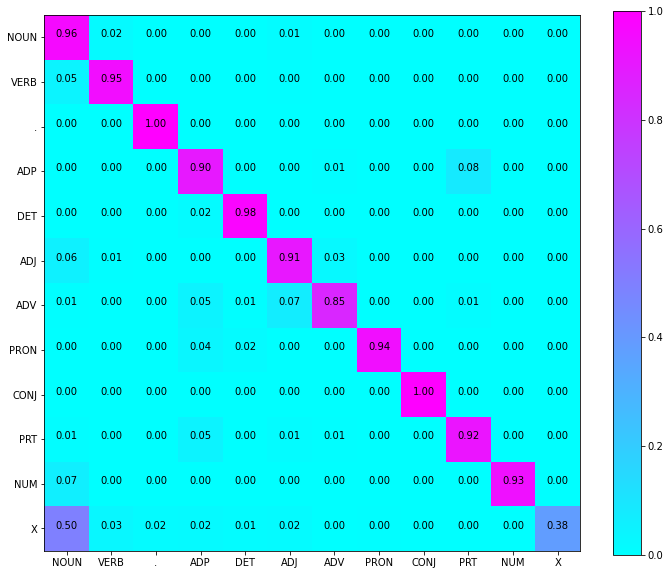

In [ ]:
plot_confusion_matrix()

In [ ]:
def plot_classification_report():
    classes = ['NOUN', 'VERB', '.', 'ADP', 'DET', 'ADJ', 'ADV', 'PRON', 'CONJ', 'PRT', 'NUM', 'X']
    report_final = np.zeros((12,3))
    support = 0
    for i in range(5):
        report = np.zeros((12,3))
        cr = classification_report(y_true_list[i],y_pred_list[i],zero_division=0)
        cr = cr.replace('macro avg', 'macro')
        cr = cr.replace('micro avg', 'micro')
        cr = cr.replace('weighted avg', 'weighted')
        cr = cr.replace('\n\n', '\n')
        lines = cr.split('\n')
        mat , sup = [], []
        for k in range(12):
            line = lines[k+1]
            a = line.strip().split()
            report[k][0] = float(a[1])
            report[k][1] = float(a[2])
            report[k][2] = float(a[3])
            sup.append(float(a[-1]))
        sup = np.array(sup)
        if(i==0):
            report_final = report
            support = sup
        else:
            report_final+=report
            support+=sup
    report_final = report_final/5.0
    support = support/5.0
    xticklabels = ['Precision', 'Recall', 'F1-Score']
    yticklabels = ['{0}[{1}]'.format(classes[i], sup_i) for i, sup_i in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(18,10))
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    plt.imshow(report_final, aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels)
    plt.yticks(np.arange(len(classes)), yticklabels)
    for i in range(report.shape[0]):
        for j in range(report.shape[1]):
            plt.text(j, i, format(report[i, j], '.2f'), horizontalalignment="center", verticalalignment="center" ,fontsize=14)

<Figure size 432x288 with 0 Axes>

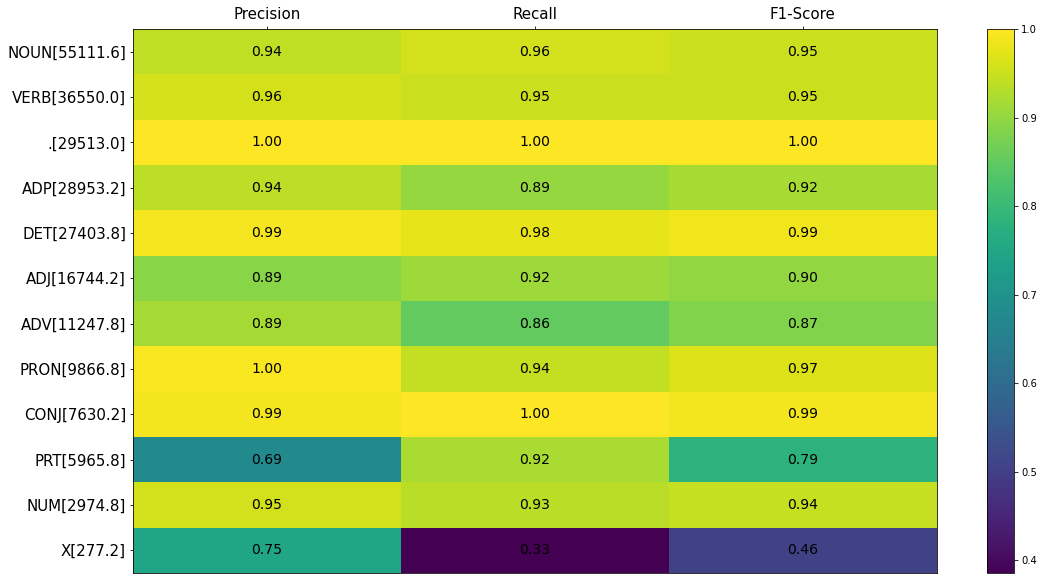

In [ ]:
plot_classification_report()

In [ ]:
f0_5_score=0
f1score=0
f2score=0
precision = 0
recall = 0
for i in range(5):
    f0_5_score+=fbeta_score(y_true_list[i],y_pred_list[i],beta=0.5,average='weighted',zero_division=0)
    f1score+=fbeta_score(y_true_list[i],y_pred_list[i],beta=1,average='weighted',zero_division=0)
    f2score+=fbeta_score(y_true_list[i],y_pred_list[i],beta=2,average='weighted',zero_division=0)
    precision+=precision_score(y_true_list[i],y_pred_list[i],average='weighted',zero_division=0)
    recall+=recall_score(y_true_list[i],y_pred_list[i],average='weighted',zero_division=0)
f0_5_score = f0_5_score/5.0
f1score = f1score/5.0
f2score = f2score/5.0
precision = precision/5.0
recall = recall/5.0

print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F0.5 Score : {f0_5_score}')
print(f'F1 Score : {f1score}')
print(f'F2 Score : {f2score}')

Precision : 0.9500519894844339
Recall : 0.9475083326189697
F0.5 Score : 0.9490836387979945
F1 Score : 0.9480437801130235
F2 Score : 0.9475248394858813


In [ ]:
sen = ['i','will','go','to','play','cricket']
sen1 = ['i','will','play','cricket','with','ram']
sen2 = ['i','dunno','about','chai','and','samosa']
predict(final_model,sen2)

['PRON', 'X', 'ADP', 'X', 'CONJ', 'X']
